In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime
from copy import deepcopy
from collections import Counter
import pickle
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/Reviews.csv')



In [3]:
data.head(4)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [4]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
data.isnull().sum()



Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [3]:
# Converting Unix time to date time
data['Time'] = pd.to_datetime(data['Time'],unit='s')
# data_sorted_by_time = data.sort_values('Time')
# Think about it
# It may be useful to implement Hidden Markov Model



# Recommendation Engine

In [4]:

# make the user ids go from 0 to N-1
# N: unique number of users
# create a mapping for user ids
unique_user_ids = set(data.UserId.values)
user2idx = {}
count = 0
for user_id in unique_user_ids:
    user2idx[user_id] = count
    count += 1
# add them to the data frame
data['user_idx'] = data.apply(lambda row: user2idx[row.UserId], axis=1)


# make the product ids go from 0 to M-1
# M: unique number of products
# create a mapping for product ids
unique_product_ids = set(data.ProductId.values)
product2idx = {}
count = 0
for product_id in unique_product_ids:
    product2idx[product_id] = count
    count += 1
# add them to the data frame
data['product_idx'] = data.apply(lambda row: product2idx[row.ProductId], axis=1)




In [5]:
N = data.user_idx.max() + 1
M = data.product_idx.max() + 1
print('Unique number of users: {}'.format(N))
print('Unique number of products: {}'.format(M))




Unique number of users: 256059
Unique number of products: 74258


In [7]:
data_recommender = data.loc[:, ['user_idx','product_idx', 'Score']]
data_recommender.head(2)



,user_idx,product_idx,Score
0,216129,70924,5
1,241655,46102,1


In [15]:
# creating a dataframe with the average rating that each users gave to products

user_ratings = pd.DataFrame(data_recommender.groupby('user_idx')['Score'].mean())
user_ratings.head()



,Score
user_idx,
0,3.000000
1,5.000000
2,5.000000
3,3.428571
4,5.000000


In [16]:
# Adding the number of ratings that each user gave

user_ratings['number_of_ratings'] = data_recommender.groupby('user_idx')['Score'].count()
user_ratings.head()



,Score,number_of_ratings
user_idx,,
0,3.000000,4
1,5.000000,2
2,5.000000,1
3,3.428571,14
4,5.000000,1


In [17]:
user_ratings.sort_values('number_of_ratings', ascending=False).head(6)



,Score,number_of_ratings
user_idx,,
253812,4.535714,448
95089,4.494062,421
176551,4.647815,389
113861,4.841096,365
44584,4.453125,256
108562,4.833333,204


In [18]:
# Let's look at the top of the distribution
user_ratings['number_of_ratings'].quantile(np.arange(.9, 1, .01))
# Around 2% of users gave 12 or more ratings.
# .02 * 256059 ~ 5121



0.90     4.0
0.91     5.0
0.92     5.0
0.93     6.0
0.94     6.0
0.95     7.0
0.96     8.0
0.97     9.0
0.98    12.0
0.99    17.0
Name: number_of_ratings, dtype: float64

In [19]:
# creating a dataframe with the average rating for each product

product_ratings = pd.DataFrame(data_recommender.groupby('product_idx')['Score'].mean())
product_ratings.head()



,Score
product_idx,
0,5.0
1,5.0
2,5.0
3,5.0
4,1.0


In [20]:
# Adding the number of ratings for each product to the ratings dataframe

product_ratings['number_of_ratings'] = data_recommender.groupby('product_idx')['Score'].count()
product_ratings.head()



,Score,number_of_ratings
product_idx,,
0,5.0,1
1,5.0,1
2,5.0,1
3,5.0,2
4,1.0,1


In [21]:
product_ratings.sort_values('number_of_ratings', ascending=False).head(10)



,Score,number_of_ratings
product_idx,,
32171,4.582694,913
6916,4.588608,632
28489,4.588608,632
44621,4.588608,632
71246,4.588608,632
69687,4.739968,623
12915,4.746032,567
52228,4.310284,564
33367,4.310284,564


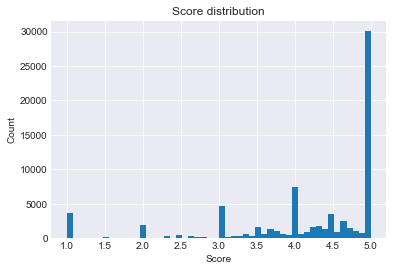

In [22]:
product_ratings['Score'].hist(bins=50)
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()



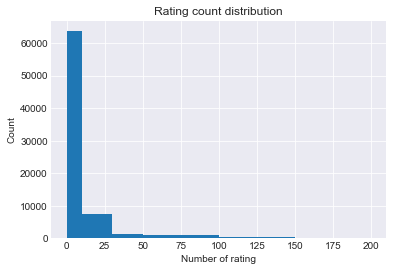

In [23]:
product_ratings['number_of_ratings'].hist(bins=[0, 10, 30, 50, 100, 150, 200])
plt.title('Rating count distribution')
plt.xlabel('Number of rating')
plt.ylabel('Count')
plt.show()



In [24]:
# Statistics of number of ratings
product_ratings['number_of_ratings'].describe()



count    74258.000000
mean         7.655121
std         26.453485
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
Name: number_of_ratings, dtype: float64

In [25]:
# Let's look at the top of the distribution
product_ratings['number_of_ratings'].quantile(np.arange(.9, 1, .01))
# Around 3% of products received 41 or more ratings.
# .03 * 74258 ~ 2227



0.90     13.0
0.91     15.0
0.92     17.0
0.93     19.0
0.94     22.0
0.95     26.0
0.96     31.0
0.97     41.0
0.98     61.0
0.99    111.0
Name: number_of_ratings, dtype: float64

In [164]:
user_ids_count = Counter(data_recommender.user_idx)
product_ids_count = Counter(data_recommender.product_idx)

# TO work with a smaller dataset, we just take a subset of dataset into account
# Accodring to our previous calculation, we just keep top 5000 users who gave the highest number of ratings
# and top 2000 products which received the highest number of ratings

n = 5000
m = 2000

# The result of "most_common" is a tuple that the first item is the key
# and the second one is the count.
# I just need the first item which is the key(user or product).
user_ids = [u for u, c in user_ids_count.most_common(n)]
product_ids = [p for p, c in product_ids_count.most_common(m)]


In [165]:
# Use ".copy()" to overwrite the data
data_small = data_recommender[data_recommender.user_idx.isin(user_ids) & 
                              data_recommender.product_idx.isin(product_ids)].copy()



In [28]:
data_small.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 69956 entries, 422 to 568062
Data columns (total 4 columns):
product_idx    69956 non-null int64
user_idx       69956 non-null int64
Score          69956 non-null int64
Time           69956 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.7 MB


In [166]:
# Right now our user ids and product ids are not sequential,
# so we make them sequential with a similar mapping as we have done before.
# make the user ids go from 0 to N-1
# N: unique number of users
# create a mapping for user ids
unique_user_ids = set(data_small.user_idx.values)
user2idx = {}
count = 0
for user_id in unique_user_ids:
    user2idx[user_id] = count
    count += 1
# add them to the data frame
data_small['user_idx'] = data_small.apply(lambda row: user2idx[row.user_idx], axis=1)


# make the product ids go from 0 to M-1
# M: unique number of products
# create a mapping for product ids
unique_product_ids = set(data_small.product_idx.values)
product2idx = {}
count = 0
for product_id in unique_product_ids:
    product2idx[product_id] = count
    count += 1
# add them to the data frame
data_small['product_idx'] = data_small.apply(lambda row: product2idx[row.product_idx], axis=1)



In [169]:
print("max user id:", data_small.user_idx.max())
print("max product id:", data_small.product_idx.max())
print("small dataframe size:", len(data_small))
data_small.to_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/small_rating.csv', index=False)



max user id: 4638
max product id: 1974
small dataframe size: 69956


In [170]:
small_rating = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/small_rating.csv')



In [171]:
small_rating.head()



,product_idx,user_idx,Score,Time
0,842,1348,4,2012-04-26
1,842,1959,5,2012-04-17
2,842,1837,5,2012-04-13
3,842,2497,4,2012-04-10
4,842,2497,4,2012-04-10


In [13]:
ratings = data_recommender.copy()
ratings.head()

,user_idx,product_idx,Score
0,216129,70924,5
1,241655,46102,1
2,167064,8981,4
3,149192,4107,2
4,182397,25838,5


In [14]:



N = ratings.user_idx.max() + 1 # number of users
M = ratings.product_idx.max() + 1 # number of products

# split into train and test
ratings = shuffle(ratings)
cutoff = int(0.9*len(data_recommender))
ratings_train = ratings[:cutoff]
ratings_test = ratings[cutoff:]

# a dictionary to tell us which users have rated which products
user2product = {}
# a dicationary to tell us which products have been rated by which users
product2user = {}
# a dictionary to look up ratings
userproduct2rating = {}

count = 0

def update_user2product_and_product2user(row):

    i = int(row.user_idx)
    j = int(row.product_idx)
    if i not in user2product:
        user2product[i] = [j]
    else:
        user2product[i].append(j)

    if j not in product2user:
        product2user[j] = [i]
    else:
        product2user[j].append(i)

    userproduct2rating[(i,j)] = row.Score
    
ratings_train.apply(update_user2product_and_product2user, axis=1)


201909    None
193036    None
49134     None
142024    None
195528    None
280166    None
349603    None
57156     None
82725     None
559881    None
256977    None
531484    None
491366    None
103706    None
258554    None
485879    None
506850    None
87588     None
398552    None
521058    None
481673    None
378329    None
465891    None
424597    None
316745    None
395654    None
384478    None
190562    None
460444    None
355201    None
          ... 
521175    None
384829    None
50013     None
56733     None
274120    None
154833    None
225301    None
95836     None
148341    None
564051    None
314579    None
429776    None
200436    None
247160    None
477366    None
443041    None
256774    None
416385    None
203052    None
109116    None
373916    None
76874     None
90087     None
84499     None
426536    None
461011    None
496539    None
122688    None
541600    None
123899    None
Length: 511608, dtype: object

In [15]:
# test ratings dictionary
userproduct2rating_test = {}

count = 0
def update_userproduct2rating_test(row):

    i = int(row.user_idx)
    j = int(row.product_idx)
    userproduct2rating_test[(i,j)] = row.Score
ratings_test.apply(update_userproduct2rating_test, axis=1)


84374     None
514824    None
504926    None
380411    None
216557    None
420120    None
194437    None
207592    None
285936    None
520202    None
147994    None
566762    None
29018     None
545661    None
31945     None
526811    None
553197    None
306780    None
44393     None
535942    None
273536    None
79263     None
299749    None
105093    None
308074    None
175258    None
390118    None
66677     None
320852    None
192822    None
          ... 
511383    None
357411    None
155450    None
355560    None
126321    None
165018    None
89569     None
393537    None
361693    None
413640    None
236850    None
56778     None
253787    None
278862    None
434611    None
520502    None
263101    None
404552    None
186463    None
360522    None
497791    None
146414    None
107672    None
232283    None
381022    None
29204     None
51995     None
365355    None
329619    None
55478     None
Length: 56846, dtype: object

In [16]:
# Save these dictionaries
with open('user2product.json', 'wb') as f:
    pickle.dump(user2product, f)

with open('product2user.json', 'wb') as f:
    pickle.dump(product2user, f)

with open('userproduct2rating.json', 'wb') as f:
    pickle.dump(userproduct2rating, f)

with open('userproduct2rating_test.json', 'wb') as f:
    pickle.dump(userproduct2rating_test, f)
    
    

# User-based collaborative filtering


* A user can be biased (optimistically or pessimistically)
* We will look at average deviation rather than average ratings


$$\huge S(u,i) = \bar r_{u} +\frac{\sum_{u' \in k}(r_{u',i} - \bar r_{u'})\times W_{u,u'}}{\sum_{u' \in k}W_{u,u'}}$$


* u: user u
* i: item i
* u': user u'
* k: Number of users that have the highest similar taste with the user u
* S(u,i): Rating for item i given by user u
* W(u,u'): Similarity between users u and u' 
* r(u',i): Rating for item i given by user u'

In [17]:
with open('user2product.json', 'rb') as f:
    user2product = pickle.load(f)

with open('product2user.json', 'rb') as f:
    product2user = pickle.load(f)

with open('userproduct2rating.json', 'rb') as f:
    userproduct2rating = pickle.load(f)

with open('userproduct2rating_test.json', 'rb') as f:
    userproduct2rating_test = pickle.load(f)
    
    

In [18]:
N = np.max(list(user2product.keys())) + 1
# the test set may contain products the train set doesn't have data on
m1 = np.max(list(product2user.keys()))
m2 = np.max([m for (u, m), r in userproduct2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)



N: 256059 M: 74258


In [317]:
# Basically we want to find k neigherest neighbors to each user according to their taste
# in choosing a product and rating it, and then we want to use it to predict what
# would be a user's rating for a product that he has not rated yet.
from sortedcontainers import SortedList
# number of neighbors we would like to take into account
K = 25 
# number of products users must have in common in order to consider them
limit = 5 
# store neighbors
neighbors = [] 
# each user's average rating
averages = [] 
# each user's rating deviation from his average rating
deviations = [] 


for i in range(N):
    # find the 25 closest users to user i
    try:
        products_i = user2product[i]
        products_i_set = set(products_i)

        # calculate avg and deviation
        ratings_i = { product:userproduct2rating[(i, product)] for product in products_i }
        avg_i = np.mean(list(ratings_i.values()))
        dev_i = { product:(rating - avg_i) for product, rating in ratings_i.items() }
        dev_i_values = np.array(list(dev_i.values()))
        sigma_i = np.sqrt(dev_i_values.dot(dev_i_values))

        # save these for later use
        averages.append(avg_i)
        deviations.append(dev_i)

        sl = SortedList()
    except KeyError:
        pass

    try:    
        for j in range(N):
        # don't include yourself

            if j != i:
                products_j = user2product[j]
                products_j_set = set(products_j)
                common_products = (products_i_set & products_j_set) # intersection


                if len(common_products) > limit:
                    # calculate avg and deviation
                    ratings_j = { product:userproduct2rating[(j, product)] for product in products_j }
                    avg_j = np.mean(list(ratings_j.values()))
                    dev_j = { product:(rating - avg_j) for product, rating in ratings_j.items() }
                    dev_j_values = np.array(list(dev_j.values()))
                    sigma_j = np.sqrt(dev_j_values.dot(dev_j_values))

                    # calculate correlation coefficient
                    numerator = sum(dev_i[m]*dev_j[m] for m in common_products)
                    w_ij = numerator / (sigma_i * sigma_j)

                    # insert into sorted list and truncate
                    # negate weight, because list is sorted ascending
                    # maximum value (1) is "closest"
                    sl.add((-w_ij, j))
                    if len(sl) > K:
                        del sl[-1]

        # store the neighbors
        neighbors.append(sl)
    except KeyError:
        pass


# using neighbors, calculate train and test MSE

def predict(i, m):
    # calculate the weighted sum of deviations
    numerator = 0
    denominator = 0

    for neg_w, j in neighbors[i]:
        # remember, the weight is stored as its negative
        # so the negative of the negative weight is the positive weight
        try:
            numerator += -neg_w * deviations[j][m]
            denominator += abs(neg_w)
        except KeyError:       
            pass
                # neighbor may not have rated the same product
                # don't want to do dictionary lookup twice
                # so just throw exception
    
    if denominator == 0:
        prediction = averages[i]
    else:
        prediction = numerator / denominator + averages[i]
    prediction = min(5, prediction)
    prediction = max(0.5, prediction) # min rating is 0.5
    return prediction
    
    

train_predictions = []
train_targets = []
try:
    for (i, m), target in userproduct2rating.items():
    # calculate the prediction for this product
    
        prediction = predict(i, m)

    # save the prediction and target
        train_predictions.append(prediction)
        train_targets.append(target)
except KeyError:
    pass
test_predictions = []
test_targets = []
# same thing for test set
try:
    for (i, m), target in userproduct2rating_test.items():
    # calculate the prediction for this product
    
        prediction = predict(i, m)

        # save the prediction and target
        test_predictions.append(prediction)
        test_targets.append(target)
except KeyError:
    pass   


# calculate accuracy
def mse(p, t):
    p = np.array(p)
    t = np.array(t)
    return np.mean((p - t)**2)

print('train mse:', mse(train_predictions, train_targets))
print('test mse:', mse(test_predictions, test_targets))

# I'm facing "IndexError" when I'm running this block of code!
# Righ now I'm so frustrated, I will take a look in the near future to see what's wrong!!


IndexError: list index out of range

# Collaborative Filtering (Cosine Similarity)

In [177]:
small_rating.head()



,product_idx,user_idx,Score,Time
37080,244,2794,5,2012-01-01
58064,316,2367,5,2010-06-23
13748,515,4231,4,2012-01-04
47659,256,496,5,2011-06-06
25277,1588,241,5,2011-06-15


In [250]:
n_users = small_rating.user_idx.unique().shape[0]
n_items = small_rating.product_idx.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

4639 users
1975 items


In [276]:
# Constructing our user-item matrix
ratings = np.zeros((n_users, n_items))
for row in small_rating.itertuples():
    ratings[row[2], row[1]] = row[3]
ratings

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]])

In [278]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))
# Just 0.71% of the user-item ratings have a value!

Sparsity: 0.71%


In [279]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2, random_state=42)



# Cosine similarity for user u and u'

$$\large Sim(u, u') = \cos(\theta) = \frac{r_{u}.r_{u'}}{|r_{u}||r_{u'}|} = \frac{\sum_i r_{ui}r_{u'i}}{\sqrt{\sum_i r_{ui}^2}\sqrt{\sum_i r_{u'i}^2}} $$

In [280]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [284]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print ('----------- User Similarity -----------')
print (user_similarity[:4, :4])
print ('----------- Product Similarity -----------')
print (item_similarity[:4, :4])

----------- User Similarity -----------
[[1.000000e+00 3.002516e-12 4.191297e-12 4.216370e-12]
 [3.002516e-12 1.000000e+00 2.831498e-12 2.848436e-12]
 [4.191297e-12 2.831498e-12 1.000000e+00 3.976214e-12]
 [4.216370e-12 2.848436e-12 3.976214e-12 1.000000e+00]]
----------- Product Similarity -----------
[[1.000000e+00 1.656744e-12 1.261712e-12 6.102479e-13]
 [1.656744e-12 1.000000e+00 1.603287e-12 1.938640e-02]
 [1.261712e-12 1.603287e-12 1.000000e+00 5.905572e-13]
 [6.102479e-13 1.938640e-02 5.905572e-13 1.000000e+00]]


### To predict the user u's rating given to item i, we can use the weighted sum of all other users' rating to item i where the weighting is the cosine similarity between user u and the other users.

$$\large \hat r_{ui} = \frac {\sum_{u'} Sim(u, u')r_{u'i}}{\sum_{u'} |Sim(u, u')|}$$

In [285]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [307]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [308]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 17.540439334040997
Item-based CF MSE: 17.831646495694304


# Top-k Collaborative Filtering

* We will only take the top k users who are most similar to the input user into account.

In [297]:
def predict_topk(ratings, similarity, kind='user', k=10):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [309]:
pred = predict_topk(train, user_similarity, kind='user', k=10)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=10)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 17.887291940936574
Top-k Item-based CF MSE: 17.866648631052456


In [300]:
k_array = [5, 10, 15, 20, 25, 30]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

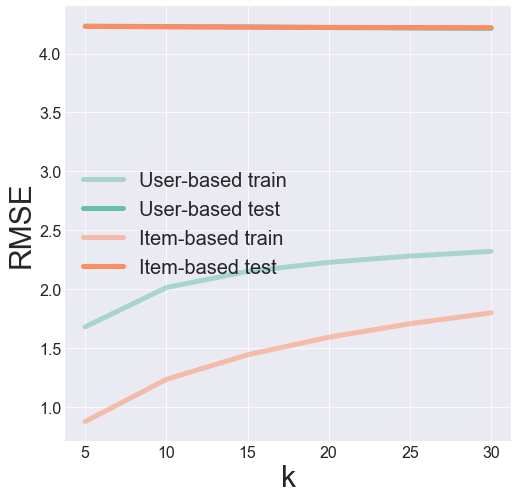

In [303]:
sns.set_style('darkgrid')
pal = sns.color_palette("Set2", 2)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

# Bias-subtracted Collaborative Filtering

* Users may tend to always give high or low ratings to all movies. As a results, it seems that the relative difference in the ratings that these users give is more important than the absolute rating values.
* A user can be biased (optimistically or pessimistically)
* We will look at average deviation rather than average ratings



$$\large \hat r_{ui} = \bar r_{u} + \frac {\sum_{u'} Sim(u, u')(r_{u'i} - \bar r_{u'} )}{\sum_{u'} |Sim(u, u')|}$$

In [304]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [310]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print ('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(train, item_similarity, kind='item')
print ('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))


Bias-subtracted User-based CF MSE: 17.583900644184723
Bias-subtracted Item-based CF MSE: 17.65915074234725


# Combining Top-k and Bias-subtracted Collaborative Filtering

In [313]:
def predict_topk_nobias(ratings, similarity, kind='user', k=10):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [314]:
user_pred = predict_topk_nobias(train, user_similarity, kind='user')
print ('Top-k Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_topk_nobias(train, item_similarity, kind='item')
print ('Top-k Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Top-k Bias-subtracted User-based CF MSE: 17.862079796434966
Top-k Bias-subtracted Item-based CF MSE: 17.898148545803153


In [315]:
k_array = [5, 10, 15, 20, 25, 30]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

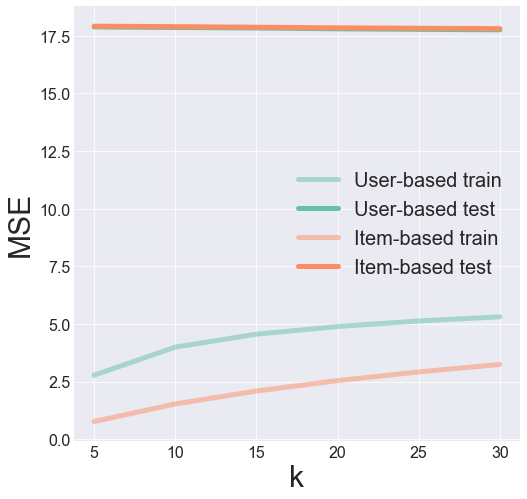

In [316]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

# Collaborative filtering by 'Surprise' package

In [202]:
# https://surprise.readthedocs.io/en/stable/getting_started.html

from surprise import Reader, Dataset, KNNBasic, evaluate    

data_surprise = small_rating.loc[: , ['user_idx', 'product_idx', 'Score']]

reader = Reader()

dataset = Dataset.load_from_df(data_surprise, reader)

# KNN
knn = KNNBasic()

evaluate(knn, dataset, measures = ['RMSE'])



Evaluating RMSE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7304
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7120
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7384
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7301
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7238
------------
------------
Mean RMSE: 0.7269
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.730440719995921,
                             0.7119559829635306,
                             0.7384038793018061,
                             0.7300556464747818,
                             0.7237970128039715]})

In [203]:
from surprise import SVD

# Singular Value Decomposition
svd = SVD()

evaluate(svd, dataset, measures = ['RMSE'])


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.7582
------------
Fold 2
RMSE: 0.7458
------------
Fold 3
RMSE: 0.7637
------------
Fold 4
RMSE: 0.7653
------------
Fold 5
RMSE: 0.7545
------------
------------
Mean RMSE: 0.7575
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.7581980479377114,
                             0.7458063815611947,
                             0.7636922120628178,
                             0.7652889253942499,
                             0.75452340696159]})

In [204]:
from surprise import NMF

# Non negative Matrix Factorization
nmf = NMF()

evaluate(nmf, dataset, measures = ['RMSE'])



Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 0.7362
------------
Fold 2
RMSE: 0.7548
------------
Fold 3
RMSE: 0.7512
------------
Fold 4
RMSE: 0.7647
------------
Fold 5
RMSE: 0.7386
------------
------------
Mean RMSE: 0.7491
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.7362486290592594,
                             0.7547521626858709,
                             0.7512052365374222,
                             0.7647384077148527,
                             0.7386306278874271]})

In [130]:

from surprise import GridSearch


param_grid = {'lr_all': [0.007, 0.008, 0.009],
              'reg_all': [0.1, 0.2, 0.3]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'])
grid_search.evaluate(dataset)



Running grid search for the following parameter combinations:
{'lr_all': 0.007, 'reg_all': 0.1}
{'lr_all': 0.007, 'reg_all': 0.2}
{'lr_all': 0.007, 'reg_all': 0.3}
{'lr_all': 0.008, 'reg_all': 0.1}
{'lr_all': 0.008, 'reg_all': 0.2}
{'lr_all': 0.008, 'reg_all': 0.3}
{'lr_all': 0.009, 'reg_all': 0.1}
{'lr_all': 0.009, 'reg_all': 0.2}
{'lr_all': 0.009, 'reg_all': 0.3}
Resulsts:
{'lr_all': 0.007, 'reg_all': 0.1}
{'RMSE': 0.7375922328542653}
----------
{'lr_all': 0.007, 'reg_all': 0.2}
{'RMSE': 0.767988277403472}
----------
{'lr_all': 0.007, 'reg_all': 0.3}
{'RMSE': 0.796003413366109}
----------
{'lr_all': 0.008, 'reg_all': 0.1}
{'RMSE': 0.7241446036693646}
----------
{'lr_all': 0.008, 'reg_all': 0.2}
{'RMSE': 0.7568968410766128}
----------
{'lr_all': 0.008, 'reg_all': 0.3}
{'RMSE': 0.7864989847746469}
----------
{'lr_all': 0.009, 'reg_all': 0.1}
{'RMSE': 0.7133740946274288}
----------
{'lr_all': 0.009, 'reg_all': 0.2}
{'RMSE': 0.7475158004561825}
----------
{'lr_all': 0.009, 'reg_all': 0.3

# Matrix Factorization with bias terms and regularization




$$\huge \hat r_{ij} = w_{i}^{T}u_{j} + b_{i} + c_{j} + \mu$$



* W(i): User vector
* u(j): Product vector
* b(i) : User bias
* c(i) : Product bias
* mu : Global average


$$\large J = \sum_{i,j \in \Omega}(r_{ij} - \hat r_{ij})^2 + \lambda (||W||_{F}^2 + ||U||_{F}^2 + ||b||_{F}^2 + ||c||_{F}^2)$$

* J: Loss function
* omega: Set of pairs (i,j) where user i rated product j
* Lambda : Regularization parameter

$$||W||_{F}^2 = \sum_{i=1}^{N} \sum_{k=1}^{K}|w_{ik}|^2 = \sum_{i=1}^{N}||w_{i}||_{2}^2 = \sum_{i=1}^{N}w_{i}^{T}w_{i}$$

# Minimizing loss function

* Set derivatives to zero and solve for w, u, b, and c
* The followings are the updates for w,u,b,c :


$$\large W_{i} = \left(\sum_{j \in \psi_{i}}u_{j}u_{j}^T + \lambda I\right)^{-1} \sum_{j \in \psi_{i}}(r_{ij} - b_{i} - c_{j} - \mu)u_{j}$$







$$\large u_{j} = \left(\sum_{i \in \Omega_{j}}W_{i}W_{i}^T + \lambda I\right)^{-1} \sum_{i \in \Omega_{j}}(r_{ij} - b_{i} - c_{j} - \mu)W_{i}$$










$$\large b_{i} = \frac{1}{\mid\psi_{i}\mid(1 + \lambda)} \sum_{j \in \psi_{i}}(r_{ij} - W_{i}^{T}u_{j} - c_{j} - \mu)$$








$$\large c_{j} = \frac{1}{\mid\Omega_{j}\mid(1 + \lambda)} \sum_{i \in \Omega_{j}}(r_{ij} - W_{i}^{T}u_{j} - b_{i} - \mu)$$







* Psi(i) : All products j that user i rated
* Omega(j) : All users i who rated product j

In [19]:
with open('user2product.json', 'rb') as f:
    user2product = pickle.load(f)

with open('product2user.json', 'rb') as f:
    product2user = pickle.load(f)

with open('userproduct2rating.json', 'rb') as f:
    userproduct2rating = pickle.load(f)

with open('userproduct2rating_test.json', 'rb') as f:
    userproduct2rating_test = pickle.load(f)
   

In [20]:
N = np.max(list(user2product.keys())) + 1
# the test set may contain products the train set doesn't have data on
m1 = np.max(list(product2user.keys()))
m2 = np.max([m for (u, m), r in userproduct2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)


N: 256059 M: 74258


epoch: 0
i: 0 N: 256059
i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:18.320583
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250 M: 74258
updated U and c: 0:00:12.322604
epoch duration: 0:00:30.643306
calculate cost: 0:00:01.167881
train loss: 1.056134588584128
test loss: 1.3109325311133648
epoch: 1
i: 0 N: 256059
i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:21.810330
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250

i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:18.053754
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250 M: 74258
updated U and c: 0:00:13.118747
epoch duration: 0:00:31.172586
calculate cost: 0:00:01.211575
train loss: 1.0450480302269607
test loss: 1.2574283747664337
epoch: 15
i: 0 N: 256059
i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:18.378796
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250 M: 74258
updated U and c: 0:00:13.101653

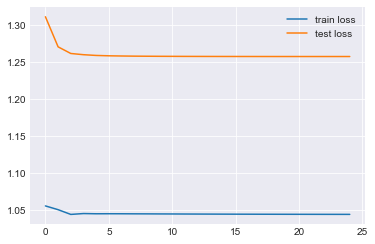

In [22]:

# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(userproduct2rating.values()))


# prediction[i,j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

def get_loss(d):
  # d: (user_id, movie_id) -> rating
    N = float(len(d)) 
    # Sum of squared error
    sse = 0
    for k, r in d.items():
        i, j = k
        p = W[i].dot(U[j]) + b[i] + c[j] + mu
        sse += (p - r)*(p - r)
    # Root mean squared error    
    return np.sqrt(sse / N)


# train the parameters
epochs = 25
reg =20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
    # perform updates

    # update W and b
    t0 = datetime.now()
    for i in range(N):
        # for W
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for b
        bi = 0
        try:
            for j in user2product[i]:
                r = userproduct2rating[(i,j)]
                matrix += np.outer(U[j], U[j])
                vector += (r - b[i] - c[j] - mu)*U[j]
                bi += (r - W[i].dot(U[j]) - c[j] - mu)

            # set the updates
            W[i] = np.linalg.solve(matrix, vector)
            b[i] = bi / (len(user2product[i]) + reg)

            if i % (N//10) == 0:
                print("i:", i, "N:", N)
        except KeyError:
            pass
    print("updated W and b:", datetime.now() - t0)

  # update U and c
    t0 = datetime.now()
    for j in range(M):
        # for U
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for c
        cj = 0
        try:
            for i in product2user[j]:
                r = userproduct2rating[(i,j)]
                matrix += np.outer(W[i], W[i])
                vector += (r - b[i] - c[j] - mu)*W[i]
                cj += (r - W[i].dot(U[j]) - b[i] - mu)

      # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(product2user[j]) + reg)

            if j % (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
            # possible not to have any ratings for a product
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(userproduct2rating))

    # store test loss
    test_losses.append(get_loss(userproduct2rating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()




# Matrix Factorization -  Vectorized

converting...
conversion done
epoch: 0
i: 0 N: 256059
i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:13.842912
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250 M: 74258
updated U and c: 0:00:05.143967
epoch duration: 0:00:18.986985
calculate cost: 0:00:01.175281
train loss: 1.1077876873075068
test loss: 1.702167837274055
epoch: 1
i: 0 N: 256059
i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:14.391395
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74

i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:13.343177
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250 M: 74258
updated U and c: 0:00:04.301997
epoch duration: 0:00:17.645489
calculate cost: 0:00:01.141405
train loss: 1.0842273023779676
test loss: 1.5685300936662292
epoch: 15
i: 0 N: 256059
i: 25605 N: 256059
i: 51210 N: 256059
i: 76815 N: 256059
i: 102420 N: 256059
i: 128025 N: 256059
i: 153630 N: 256059
i: 179235 N: 256059
i: 204840 N: 256059
i: 230445 N: 256059
i: 256050 N: 256059
updated W and b: 0:00:13.341526
j: 0 M: 74258
j: 7425 M: 74258
j: 14850 M: 74258
j: 22275 M: 74258
j: 29700 M: 74258
j: 37125 M: 74258
j: 44550 M: 74258
j: 51975 M: 74258
j: 59400 M: 74258
j: 74250 M: 74258
updated U an

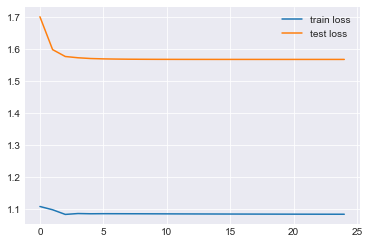

In [21]:
# convert user2product and product2user to include ratings
print("converting...")
user2productrating = {}
for i, products in user2product.items():
    r = np.array([userproduct2rating[(i,j)] for j in products])
    user2productrating[i] = (products, r)
product2userrating = {}
for j, users in product2user.items():
    r = np.array([userproduct2rating[(i,j)] for i in users])
    product2userrating[j] = (users, r)

# create a product2user for test set, since we need it for loss
product2userrating_test = {}
for (i, j), r in userproduct2rating_test.items():
    if j not in product2userrating_test:
        product2userrating_test[j] = [[i], [r]]
    else:
        product2userrating_test[j][0].append(i)
        product2userrating_test[j][1].append(r)
for j, (users, r) in product2userrating_test.items():
    product2userrating_test[j][1] = np.array(r)
print("conversion done")

# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(userproduct2rating.values()))



def get_loss(m2u):
  # d: movie_id -> (user_ids, ratings)
    N = 0.
    sse = 0
    for j, (u_ids, r) in m2u.items():
        p = W[u_ids].dot(U[j]) + b[u_ids] + c[j] + mu
        delta = p - r
        sse += delta.dot(delta)
        N += len(r)
    return sse / N



# train the parameters
epochs = 25
reg = 20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
  # perform updates

  # update W and b
    t0 = datetime.now()
    for i in range(N):
        try:
            m_ids, r = user2productrating[i]
            matrix = U[m_ids].T.dot(U[m_ids]) + np.eye(K) * reg
            vector = (r - b[i] - c[m_ids] - mu).dot(U[m_ids])
            bi = (r - U[m_ids].dot(W[i]) - c[m_ids] - mu).sum()

            # set the updates
            W[i] = np.linalg.solve(matrix, vector)
            b[i] = bi / (len(user2product[i]) + reg)

            if i % (N//10) == 0:
                print("i:", i, "N:", N)
        except KeyError:
            pass
    print("updated W and b:", datetime.now() - t0)


    # update U and c
    t0 = datetime.now()
    for j in range(M):
        try:
            u_ids, r = product2userrating[j]
            matrix = W[u_ids].T.dot(W[u_ids]) + np.eye(K) * reg
            vector = (r - b[u_ids] - c[j] - mu).dot(W[u_ids])
            cj = (r - W[u_ids].dot(U[j]) - b[u_ids] - mu).sum()

            # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(product2user[j]) + reg)

            if j % (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
          # possible not to have any ratings for a product
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(product2userrating))

    # store test loss
    test_losses.append(get_loss(product2userrating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()





# Matrix Factorization in Keras




In [6]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam



Using TensorFlow backend.


In [7]:
data = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/Reviews.csv')

data.shape



(568454, 10)

In [8]:


# make the user ids go from 0 to N-1
# N: unique number of users
# create a mapping for user ids
unique_user_ids = set(data.UserId.values)
user2idx = {}
count = 0
for user_id in unique_user_ids:
    user2idx[user_id] = count
    count += 1
# add them to the data frame
data['user_idx'] = data.apply(lambda row: user2idx[row.UserId], axis=1)


# make the product ids go from 0 to M-1
# M: unique number of products
# create a mapping for product ids
unique_product_ids = set(data.ProductId.values)
product2idx = {}
count = 0
for product_id in unique_product_ids:
    product2idx[product_id] = count
    count += 1
# add them to the data frame
data['product_idx'] = data.apply(lambda row: product2idx[row.ProductId], axis=1)



In [9]:
ratings = data.loc[:, ['user_idx', 'product_idx', 'Score']]
ratings.head()



,user_idx,product_idx,Score
0,238537,72996,5
1,164293,28451,1
2,21055,1547,4
3,122785,11602,2
4,38163,13481,5


Train on 511608 samples, validate on 56846 samples
Epoch 1/15
511608/511608 [==============================] - 165s 323us/step - loss: 1.6074 - mean_squared_error: 1.6074 - val_loss: 1.5365 - val_mean_squared_error: 1.5365
Epoch 2/15
511608/511608 [==============================] - 182s 356us/step - loss: 1.4379 - mean_squared_error: 1.4379 - val_loss: 1.4593 - val_mean_squared_error: 1.4593
Epoch 3/15
511608/511608 [==============================] - 195s 381us/step - loss: 1.3250 - mean_squared_error: 1.3250 - val_loss: 1.4035 - val_mean_squared_error: 1.4035
Epoch 4/15
511608/511608 [==============================] - 193s 378us/step - loss: 1.2351 - mean_squared_error: 1.2351 - val_loss: 1.3604 - val_mean_squared_error: 1.3604
Epoch 5/15
511608/511608 [==============================] - 191s 373us/step - loss: 1.1591 - mean_squared_error: 1.1591 - val_loss: 1.3228 - val_mean_squared_error: 1.3228
Epoch 6/15
511608/511608 [==============================] - 199s 389us/step - loss: 1.090

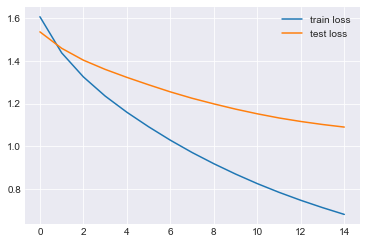

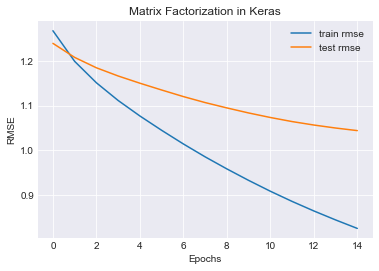

In [10]:



N = ratings.user_idx.max() + 1 # number of users
M = ratings.product_idx.max() + 1 # number of items

# split into train and test
ratings = shuffle(ratings)
cutoff = int(0.9*len(ratings))
ratings_train = ratings[:cutoff]
ratings_test = ratings[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = ratings_train.Score.mean()
epochs = 15
reg = 0. # regularization penalty


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)

# subsubmodel = Model([u, m], [u_embedding, m_embedding])
# user_ids = df_train.user_idx.values[0:5]
# product_ids = df_train.product_idx.values[0:5]
# print("user_ids.shape", user_ids.shape)
# p = subsubmodel.predict([user_ids, product_ids])
# print("p[0].shape:", p[0].shape)
# print("p[1].shape:", p[1].shape)
# exit()


u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)

# submodel = Model([u, m], x)
# user_ids = df_train.user_idx.values[0:5]
# product_ids = df_train.product_idx.values[0:5]
# p = submodel.predict([user_ids, product_ids])
# print("p.shape:", p.shape)
# exit()


x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse']
)

r = model.fit(
  x=[ratings_train.user_idx.values, ratings_train.product_idx.values],
  y=ratings_train.Score.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [ratings_test.user_idx.values, ratings_test.product_idx.values],
    ratings_test.Score.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot rmse
plt.plot(np.sqrt(r.history['mean_squared_error']), label="train rmse")
plt.plot(np.sqrt(r.history['val_mean_squared_error']), label="test rmse")
plt.legend()
plt.title('Matrix Factorization in Keras')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.savefig('keras_mf.png')
plt.show()






# Recommendation with Deep Neural Network

In [35]:
ratings = data.loc[:, ['user_idx', 'product_idx', 'Score']]
ratings.head()




,user_idx,product_idx,Score
0,167739,47541,5
1,198571,66018,1
2,164031,47038,4
3,255857,72119,2
4,113656,52015,5


In [11]:

N = ratings.user_idx.max() + 1 # number of users
M = ratings.product_idx.max() + 1 # number of items

# split into train and test
ratings = shuffle(ratings)
cutoff = int(0.9*len(ratings))
ratings_train = ratings[:cutoff]
ratings_test = ratings[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = ratings_train.Score.mean()
epochs = 15
reg = 0. # regularization penalty

Train on 511608 samples, validate on 56846 samples
Epoch 1/15
511608/511608 [==============================] - 144s 282us/step - loss: 1.5581 - mean_squared_error: 1.5581 - val_loss: 1.2782 - val_mean_squared_error: 1.2782
Epoch 2/15
511608/511608 [==============================] - 155s 303us/step - loss: 0.8885 - mean_squared_error: 0.8885 - val_loss: 1.1481 - val_mean_squared_error: 1.1481
Epoch 3/15
511608/511608 [==============================] - 161s 315us/step - loss: 0.4389 - mean_squared_error: 0.4389 - val_loss: 1.1490 - val_mean_squared_error: 1.1490
Epoch 4/15
511608/511608 [==============================] - 165s 323us/step - loss: 0.3239 - mean_squared_error: 0.3239 - val_loss: 1.1880 - val_mean_squared_error: 1.1880
Epoch 5/15
511608/511608 [==============================] - 164s 320us/step - loss: 0.2569 - mean_squared_error: 0.2569 - val_loss: 1.1690 - val_mean_squared_error: 1.1690
Epoch 6/15
511608/511608 [==============================] - 188s 368us/step - loss: 0.207

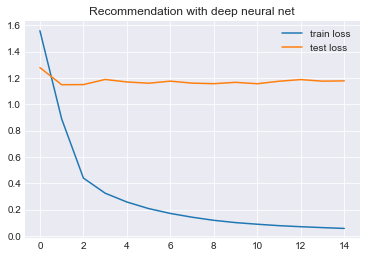

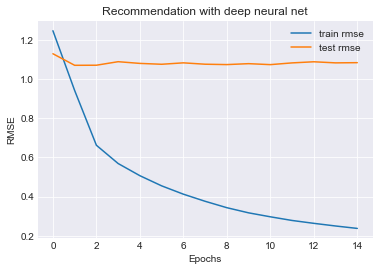

In [12]:


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = Dense(400)(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(100)(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

r = model.fit(
  x=[ratings_train.user_idx.values, ratings_train.product_idx.values],
  y=ratings_train.Score.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [ratings_test.user_idx.values, ratings_test.product_idx.values],
    ratings_test.Score.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.title('Recommendation with deep neural net')
plt.legend()
plt.show()

# plot rmse
plt.plot(np.sqrt(r.history['mean_squared_error']), label="train rmse")
plt.plot(np.sqrt(r.history['val_mean_squared_error']), label="test rmse")
plt.title('Recommendation with deep neural net')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()



# Recommendation with Residual learning

Train on 511608 samples, validate on 56846 samples
Epoch 1/15
511608/511608 [==============================] - 140s 274us/step - loss: 1.4427 - mean_squared_error: 1.4427 - val_loss: 1.1885 - val_mean_squared_error: 1.1885
Epoch 2/15
511608/511608 [==============================] - 146s 286us/step - loss: 0.7831 - mean_squared_error: 0.7831 - val_loss: 1.1833 - val_mean_squared_error: 1.1833
Epoch 3/15
511608/511608 [==============================] - 148s 289us/step - loss: 0.5073 - mean_squared_error: 0.5073 - val_loss: 1.1577 - val_mean_squared_error: 1.1577
Epoch 4/15
511608/511608 [==============================] - 159s 311us/step - loss: 0.4207 - mean_squared_error: 0.4207 - val_loss: 1.1310 - val_mean_squared_error: 1.1310
Epoch 5/15
511608/511608 [==============================] - 185s 362us/step - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 1.1756 - val_mean_squared_error: 1.1756
Epoch 6/15
511608/511608 [==============================] - 169s 330us/step - loss: 0.313

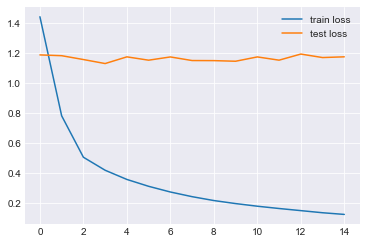

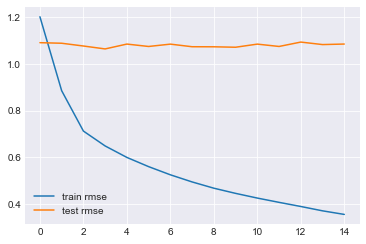

In [29]:


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)


##### main branch
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)


##### side branch
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)


##### merge
x = Add()([x, y])

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

r = model.fit(
  x=[ratings_train.user_idx.values, ratings_train.product_idx.values],
  y=ratings_train.Score.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [ratings_test.user_idx.values, ratings_test.product_idx.values],
    ratings_test.Score.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot rmse
plt.plot(np.sqrt(r.history['mean_squared_error']), label="train rmse")
plt.plot(np.sqrt(r.history['val_mean_squared_error']), label="test rmse")
plt.legend()
plt.show()

# Probabilistic Matrix Factorization

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime
from copy import deepcopy
from collections import Counter
import pickle
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')


In [9]:
data = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/Reviews.csv')


In [11]:
data.shape

(568454, 12)

In [10]:


# make the user ids go from 0 to N-1
# N: unique number of users
# create a mapping for user ids
unique_user_ids = set(data.UserId.values)
user2idx = {}
count = 0
for user_id in unique_user_ids:
    user2idx[user_id] = count
    count += 1
# add them to the data frame
data['user_idx'] = data.apply(lambda row: user2idx[row.UserId], axis=1)


# make the product ids go from 0 to M-1
# M: unique number of products
# create a mapping for product ids
unique_product_ids = set(data.ProductId.values)
product2idx = {}
count = 0
for product_id in unique_product_ids:
    product2idx[product_id] = count
    count += 1
# add them to the data frame
data['product_idx'] = data.apply(lambda row: product2idx[row.ProductId], axis=1)






In [11]:
data_pmf = data.loc[:, ['user_idx', 'product_idx', 'Score']]
data_pmf = np.array(data_pmf)



In [13]:
# split into train and test
data_pmf = shuffle(data_pmf)
cutoff = int(0.9*len(data_pmf))
data_pmf_train = data_pmf[:cutoff]
data_pmf_test = data_pmf[cutoff:]
data_pmf_train = np.array(data_pmf_train)
data_pmf_test = np.array(data_pmf_test)



In [42]:
# -*- coding: utf-8 -*-
import numpy as np


class PMF(object):
    def __init__(self, num_feat=10, epsilon=0.005, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=52, batch_size=10000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # 

        pairs_train = train_vec.shape[0]  # traindata 
        pairs_test = test_vec.shape[0]  # testdata

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # user
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # movie

        incremental = False  
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn  M x D 
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn  N x D 

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  # M x D 
            self.w_User_inc = np.zeros((num_user, self.num_feat))  #  N x D 

        while self.epoch < self.maxepoch:  # 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # array
            np.random.shuffle(shuffled_order)  #

            # Batch update
            for batch in range(self.num_batches):  # 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # 

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)
    
    
    

Training RMSE: 1.310883, Test RMSE 1.318728
Training RMSE: 1.310607, Test RMSE 1.318713
Training RMSE: 1.310334, Test RMSE 1.318698
Training RMSE: 1.310061, Test RMSE 1.318682
Training RMSE: 1.309788, Test RMSE 1.318664
Training RMSE: 1.309515, Test RMSE 1.318644
Training RMSE: 1.309240, Test RMSE 1.318619
Training RMSE: 1.308961, Test RMSE 1.318591
Training RMSE: 1.308678, Test RMSE 1.318558
Training RMSE: 1.308390, Test RMSE 1.318519
Training RMSE: 1.308095, Test RMSE 1.318473
Training RMSE: 1.307790, Test RMSE 1.318418
Training RMSE: 1.307476, Test RMSE 1.318352
Training RMSE: 1.307149, Test RMSE 1.318276
Training RMSE: 1.306807, Test RMSE 1.318185
Training RMSE: 1.306449, Test RMSE 1.318079
Training RMSE: 1.306069, Test RMSE 1.317953
Training RMSE: 1.305667, Test RMSE 1.317806
Training RMSE: 1.305240, Test RMSE 1.317638
Training RMSE: 1.304786, Test RMSE 1.317445


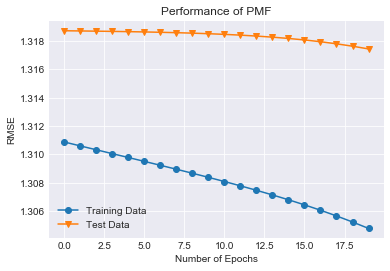

precision_acc,recall_acc:(1.9975585395627563e-05, 0.00018865830651426034)


In [43]:



if __name__ == "__main__":
    
    pmf = PMF()
    pmf.set_params({"num_feat": 10, "epsilon": 0.005, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 52,
                    "batch_size": 10000})
    
    
    
    pmf.fit(data_pmf_train, data_pmf_test)

    # Check performance by plotting train and test errors
    sns.set_style('darkgrid')
    plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
    plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
    plt.title('Performance of PMF')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    print("precision_acc,recall_acc:" + str(pmf.topK(data_pmf_test)))
    
    
    

In [ ]:
5	Training RMSE: 1.306833, Test RMSE 1.317166

10     Training RMSE: 1.304278, Test RMSE 1.316897

15     Training RMSE: 1.302277, Test RMSE 1.316702
25     Training RMSE: 1.297944, Test RMSE 1.316330
40     Training RMSE: 1.291402, Test RMSE 1.315203
50     Training RMSE: 1.287516, Test RMSE 1.314937


In [26]:
feat = [5, 10, 15, 25, 40, 50]
train = [1.306833, 1.304278, 1.302277,1.297944, 1.291402,1.287516]
test =[1.317166,1.316897,1.316702,1.316330,1.315203,1.314937]

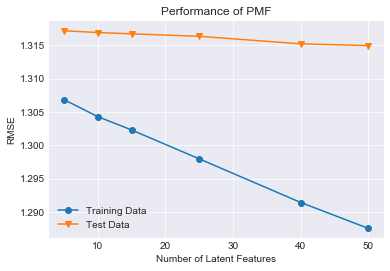

In [41]:
sns.set_style('darkgrid')
plt.plot(feat, train, marker='o', label='Training Data')
plt.plot(feat, test, marker='v', label='Test Data')
plt.title('Performance of PMF')
plt.xlabel('Number of Latent Features')
plt.ylabel('RMSE')
plt.legend()
plt.show()

